In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import urllib

In [2]:
print(cv.__version__)

4.5.1


In [3]:
req = urllib.request.urlopen('https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/box.png')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img1  = cv.imdecode(arr, cv.IMREAD_GRAYSCALE ) # 'Load it as grayscale'
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

req = urllib.request.urlopen('https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/box_in_scene.png')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img2 = cv.imdecode(arr, cv.IMREAD_GRAYSCALE ) # 'Load it as grayscale'

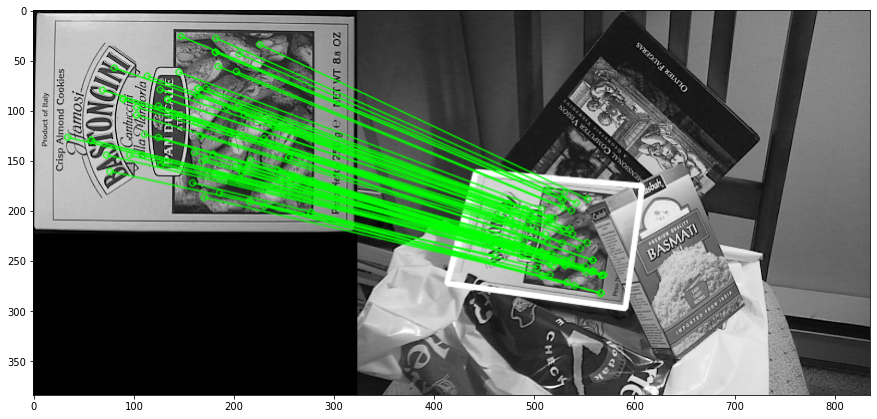

(<matplotlib.image.AxesImage at 0x7f16280d4790>, None)

In [6]:
MIN_MATCH_COUNT = 10


# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3, 'gray'),plt.show()